### Import Packages


In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.layers import Input, Dense, Embedding, MaxPooling1D, Conv1D, SpatialDropout1D
from keras.layers import add, Dropout, PReLU, BatchNormalization, GlobalMaxPooling1D, MaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import optimizers
from keras import initializers, regularizers, constraints, callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [30]:
print(tf.__version__)

2.2.0


### Read in datafile and Extract input and labels


In [2]:
train = pd.read_csv("TIL_NLP_train_dataset.csv")
test = pd.read_csv("TIL_NLP_test_dataset.csv")
print(train.shape)
print(test.shape)

train_input = train["word_representation"]
train_labels = train[train.columns[2:]]
test_input = test["word_representation"]
test_id = test["id"]

print(train_input.head(1))
print(train_labels.head(1))
print(test_input.head(1))

x_train, x_test, y_train, y_test = train_test_split(train_input, train_labels, test_size=0.15, shuffle = True, random_state = 255)

(7380, 7)
(2460, 2)
0    w7718 w173355 w138132 w232277 w90685 w314686 w...
Name: word_representation, dtype: object
   outwear  top  trousers  women dresses  women skirts
0        1    0         1              0             0
0    w373517 w383437 w374393 w87179 w289496 w327385...
Name: word_representation, dtype: object


In [3]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

def schedule(ind):
    a = [0.001, 0.0005, 0.0001, 0.0001]
    return a[ind] 

### Tokenise and pad

In [4]:
max_features = 100000
maxlen = 100
embed_size = 100

print('preprocessing start')

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train) + list(x_test) + list(test_input))

X_train1 = tokenizer.texts_to_sequences(x_train)
X_test1 = tokenizer.texts_to_sequences(x_test)
x_train_seq = sequence.pad_sequences(X_train1, maxlen=maxlen)
x_test_seq = sequence.pad_sequences(X_test1, maxlen=maxlen)


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


preprocessing start
Found 4620 unique tokens.


### Create embedding dictionary and matrix

In [5]:
### Read pkl file provided
import gc
import pickle 
with open("word_embeddings.pkl",'rb') as g:
    embeddings_index = pickle.load(g)

all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = len(word_index)+1
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
print('preprocessing done')


/Users/ashleyho/opt/anaconda3/envs/BH2020/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


preprocessing done


In [6]:
filter_nr = 64
filter_size = 6
max_pool_size = 4
max_pool_strides = 2
dense_nr = 512
spatial_dropout = 0.2
dense_dropout = 0.5
train_embed = False
conv_kern_reg = regularizers.l2(0.00001)
conv_bias_reg = regularizers.l2(0.00001)


In [7]:
model = Sequential()
model.add(Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=train_embed))
model.add(Conv1D(filters = 256, kernel_size=6, padding='same', activation='relu',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(Dropout(0.5))
model.add(Conv1D(filters = 128, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(BatchNormalization())
model.add(Conv1D(filters = 64, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(Conv1D(filters = 32, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(Dropout(0.2))
model.add(Conv1D(filters = 16, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(BatchNormalization())
model.add(Conv1D(filters = 8, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         462100    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         153856    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         196736    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 128)         512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          49216     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          1

In [8]:
batch_size = 128
epochs = 50

Xtrain, Xval, ytrain, yval = train_test_split(x_train_seq, y_train, train_size=0.90, random_state=233, shuffle = True)
history = model.fit(Xtrain, ytrain, batch_size=batch_size, epochs=epochs, 
                    validation_data=(Xval, yval),verbose=1, shuffle = True,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Epoch 1/50
45/45 [==============================] - 14s 316ms/step - loss: 0.5642 - accuracy: 0.2002 - val_loss: 0.5364 - val_accuracy: 0.2070
Epoch 2/50
45/45 [==============================] - 14s 303ms/step - loss: 0.4862 - accuracy: 0.2590 - val_loss: 0.4943 - val_accuracy: 0.5271
Epoch 3/50
45/45 [==============================] - 14s 306ms/step - loss: 0.3400 - accuracy: 0.4748 - val_loss: 0.3524 - val_accuracy: 0.5159
Epoch 4/50
45/45 [==============================] - 14s 315ms/step - loss: 0.2608 - accuracy: 0.5166 - val_loss: 0.2530 - val_accuracy: 0.5573
Epoch 5/50
45/45 [==============================] - 15s 338ms/step - loss: 0.2025 - accuracy: 0.5741 - val_loss: 0.3147 - val_accuracy: 0.6385
Epoch 6/50
45/45 [==============================] - 16s 348ms/step - loss: 0.1560 - accuracy: 0.5366 - val_loss: 0.1911 - val_accuracy: 0.5860
Epoch 7/50
45/45 [==============================] - 15s 323ms/step - loss: 0.1087 - accuracy: 0.5074 - val_loss: 0.1215 - val_accuracy: 0.5414

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


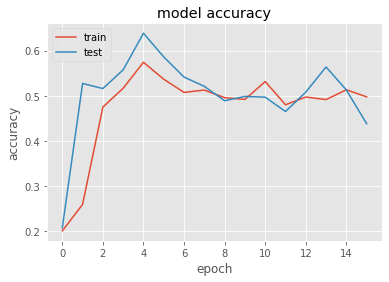

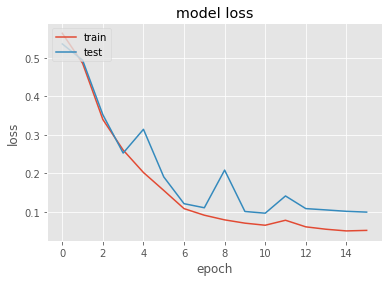

In [11]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
y_pred_NN = model.predict(x_test_seq, verbose=0)
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in y_pred_NN]

### TFIDF for CatBoost and LinearSVC

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = TfidfVectorizer(analyzer='word', ngram_range=(1,6),max_df=1.0,
                        max_features=None, min_df=1)

cvect.fit(x_train)
x_train_vectorized = cvect.transform(x_train)
x_test_vectorized = cvect.transform(x_test)

print(x_train_vectorized.shape)
print(x_test_vectorized.shape)
print(y_train.shape)

(6273, 288021)
(1107, 288021)
(6273, 5)


### LinearSVC

In [15]:
clf1 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 
clf2 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 
clf3 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 
clf4 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 
clf5 = CalibratedClassifierCV(LinearSVC(C=0.32, penalty="l2")) 

"outwear", "top", "trousers", "women dresses", "women skirts"
clf1.fit(x_train_vectorized, y_train["outwear"])
clf2.fit(x_train_vectorized, y_train["top"])
clf3.fit(x_train_vectorized, y_train["trousers"])
clf4.fit(x_train_vectorized, y_train["women dresses"])
clf5.fit(x_train_vectorized, y_train["women skirts"])


y_pred1 = clf1.predict_proba(x_test_vectorized)[:, 1]
y_pred2 = clf2.predict_proba(x_test_vectorized)[:, 1]
y_pred3 = clf3.predict_proba(x_test_vectorized)[:, 1]
y_pred4 = clf4.predict_proba(x_test_vectorized)[:, 1]
y_pred5 = clf5.predict_proba(x_test_vectorized)[:, 1]

y_pred_class_SVC = np.stack((y_pred1,y_pred2,y_pred3, y_pred4, y_pred5), axis = 1)

In [16]:
from sklearn.metrics import accuracy_score 
y_pred1 = clf1.predict(x_test_vectorized)
y_pred2 = clf2.predict(x_test_vectorized)
y_pred3 = clf3.predict(x_test_vectorized)
y_pred4 = clf4.predict(x_test_vectorized)
y_pred5 = clf5.predict(x_test_vectorized)

y_pred = np.stack((y_pred1,y_pred2,y_pred3, y_pred4, y_pred5), axis = 1)
print("Accuracy score using CountVectorizer and LinearSVC: {}".format(accuracy_score(y_pred, y_test)))

Accuracy score using CountVectorizer and LinearSVC: 0.7533875338753387


### CatBoost


In [18]:
from catboost import CatBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

ovr = OneVsRestClassifier(estimator=CatBoostClassifier(loss_function='MultiClass',eval_metric='AUC'
                                                       , verbose=1,learning_rate = 0.1,
                                                      iterations = 1000, rsm = 0.1))
ovr.fit(x_train_vectorized,y_train)

y_pred = ovr.predict(x_test_vectorized)


from sklearn.metrics import accuracy_score 
print("Accuracy score using CountVectorizer and CatBoost: {}".format(accuracy_score(y_pred, y_test)))

0:	total: 892ms	remaining: 14m 51s
1:	total: 1.55s	remaining: 12m 54s
2:	total: 2.21s	remaining: 12m 12s
3:	total: 2.86s	remaining: 11m 53s
4:	total: 3.54s	remaining: 11m 43s
5:	total: 4.18s	remaining: 11m 32s
6:	total: 4.84s	remaining: 11m 26s
7:	total: 5.49s	remaining: 11m 20s
8:	total: 6.14s	remaining: 11m 16s
9:	total: 6.79s	remaining: 11m 11s
10:	total: 7.43s	remaining: 11m 8s
11:	total: 8.08s	remaining: 11m 5s
12:	total: 8.72s	remaining: 11m 2s
13:	total: 9.37s	remaining: 11m
14:	total: 10s	remaining: 10m 58s
15:	total: 10.7s	remaining: 10m 56s
16:	total: 11.3s	remaining: 10m 54s
17:	total: 12s	remaining: 10m 52s
18:	total: 12.6s	remaining: 10m 50s
19:	total: 13.2s	remaining: 10m 48s
20:	total: 13.9s	remaining: 10m 46s
21:	total: 14.5s	remaining: 10m 45s
22:	total: 15.2s	remaining: 10m 45s
23:	total: 15.8s	remaining: 10m 43s
24:	total: 16.5s	remaining: 10m 44s
25:	total: 17.2s	remaining: 10m 43s
26:	total: 17.8s	remaining: 10m 42s
27:	total: 18.5s	remaining: 10m 41s
28:	total: 19

228:	total: 2m 32s	remaining: 8m 34s
229:	total: 2m 33s	remaining: 8m 33s
230:	total: 2m 33s	remaining: 8m 32s
231:	total: 2m 34s	remaining: 8m 31s
232:	total: 2m 35s	remaining: 8m 31s
233:	total: 2m 35s	remaining: 8m 30s
234:	total: 2m 36s	remaining: 8m 29s
235:	total: 2m 37s	remaining: 8m 29s
236:	total: 2m 37s	remaining: 8m 28s
237:	total: 2m 38s	remaining: 8m 27s
238:	total: 2m 39s	remaining: 8m 26s
239:	total: 2m 39s	remaining: 8m 26s
240:	total: 2m 40s	remaining: 8m 25s
241:	total: 2m 41s	remaining: 8m 25s
242:	total: 2m 41s	remaining: 8m 24s
243:	total: 2m 42s	remaining: 8m 23s
244:	total: 2m 43s	remaining: 8m 23s
245:	total: 2m 43s	remaining: 8m 22s
246:	total: 2m 44s	remaining: 8m 21s
247:	total: 2m 45s	remaining: 8m 20s
248:	total: 2m 45s	remaining: 8m 20s
249:	total: 2m 46s	remaining: 8m 19s
250:	total: 2m 47s	remaining: 8m 18s
251:	total: 2m 47s	remaining: 8m 18s
252:	total: 2m 48s	remaining: 8m 17s
253:	total: 2m 49s	remaining: 8m 16s
254:	total: 2m 49s	remaining: 8m 15s
2

453:	total: 4m 55s	remaining: 5m 55s
454:	total: 4m 56s	remaining: 5m 55s
455:	total: 4m 57s	remaining: 5m 54s
456:	total: 4m 57s	remaining: 5m 53s
457:	total: 4m 58s	remaining: 5m 53s
458:	total: 4m 59s	remaining: 5m 52s
459:	total: 4m 59s	remaining: 5m 51s
460:	total: 5m	remaining: 5m 51s
461:	total: 5m 1s	remaining: 5m 50s
462:	total: 5m 1s	remaining: 5m 49s
463:	total: 5m 2s	remaining: 5m 49s
464:	total: 5m 3s	remaining: 5m 48s
465:	total: 5m 3s	remaining: 5m 47s
466:	total: 5m 4s	remaining: 5m 47s
467:	total: 5m 5s	remaining: 5m 46s
468:	total: 5m 5s	remaining: 5m 46s
469:	total: 5m 6s	remaining: 5m 45s
470:	total: 5m 7s	remaining: 5m 44s
471:	total: 5m 7s	remaining: 5m 44s
472:	total: 5m 8s	remaining: 5m 43s
473:	total: 5m 9s	remaining: 5m 43s
474:	total: 5m 9s	remaining: 5m 42s
475:	total: 5m 10s	remaining: 5m 41s
476:	total: 5m 11s	remaining: 5m 41s
477:	total: 5m 11s	remaining: 5m 40s
478:	total: 5m 12s	remaining: 5m 39s
479:	total: 5m 13s	remaining: 5m 39s
480:	total: 5m 13s	

678:	total: 7m 23s	remaining: 3m 29s
679:	total: 7m 24s	remaining: 3m 29s
680:	total: 7m 25s	remaining: 3m 28s
681:	total: 7m 25s	remaining: 3m 27s
682:	total: 7m 26s	remaining: 3m 27s
683:	total: 7m 27s	remaining: 3m 26s
684:	total: 7m 27s	remaining: 3m 25s
685:	total: 7m 28s	remaining: 3m 25s
686:	total: 7m 28s	remaining: 3m 24s
687:	total: 7m 29s	remaining: 3m 23s
688:	total: 7m 30s	remaining: 3m 23s
689:	total: 7m 31s	remaining: 3m 22s
690:	total: 7m 31s	remaining: 3m 21s
691:	total: 7m 32s	remaining: 3m 21s
692:	total: 7m 32s	remaining: 3m 20s
693:	total: 7m 33s	remaining: 3m 20s
694:	total: 7m 34s	remaining: 3m 19s
695:	total: 7m 34s	remaining: 3m 18s
696:	total: 7m 35s	remaining: 3m 18s
697:	total: 7m 36s	remaining: 3m 17s
698:	total: 7m 36s	remaining: 3m 16s
699:	total: 7m 37s	remaining: 3m 16s
700:	total: 7m 38s	remaining: 3m 15s
701:	total: 7m 39s	remaining: 3m 14s
702:	total: 7m 39s	remaining: 3m 14s
703:	total: 7m 40s	remaining: 3m 13s
704:	total: 7m 40s	remaining: 3m 12s
7

902:	total: 9m 48s	remaining: 1m 3s
903:	total: 9m 49s	remaining: 1m 2s
904:	total: 9m 49s	remaining: 1m 1s
905:	total: 9m 50s	remaining: 1m 1s
906:	total: 9m 51s	remaining: 1m
907:	total: 9m 51s	remaining: 60s
908:	total: 9m 52s	remaining: 59.3s
909:	total: 9m 53s	remaining: 58.7s
910:	total: 9m 53s	remaining: 58s
911:	total: 9m 54s	remaining: 57.3s
912:	total: 9m 54s	remaining: 56.7s
913:	total: 9m 55s	remaining: 56s
914:	total: 9m 56s	remaining: 55.4s
915:	total: 9m 56s	remaining: 54.7s
916:	total: 9m 57s	remaining: 54.1s
917:	total: 9m 58s	remaining: 53.4s
918:	total: 9m 58s	remaining: 52.8s
919:	total: 9m 59s	remaining: 52.1s
920:	total: 9m 59s	remaining: 51.5s
921:	total: 10m	remaining: 50.8s
922:	total: 10m 1s	remaining: 50.2s
923:	total: 10m 1s	remaining: 49.5s
924:	total: 10m 2s	remaining: 48.8s
925:	total: 10m 3s	remaining: 48.2s
926:	total: 10m 3s	remaining: 47.5s
927:	total: 10m 4s	remaining: 46.9s
928:	total: 10m 4s	remaining: 46.2s
929:	total: 10m 5s	remaining: 45.6s
930:

131:	total: 1m 25s	remaining: 9m 21s
132:	total: 1m 26s	remaining: 9m 20s
133:	total: 1m 26s	remaining: 9m 19s
134:	total: 1m 27s	remaining: 9m 19s
135:	total: 1m 27s	remaining: 9m 18s
136:	total: 1m 28s	remaining: 9m 17s
137:	total: 1m 29s	remaining: 9m 16s
138:	total: 1m 29s	remaining: 9m 16s
139:	total: 1m 30s	remaining: 9m 15s
140:	total: 1m 31s	remaining: 9m 14s
141:	total: 1m 31s	remaining: 9m 14s
142:	total: 1m 32s	remaining: 9m 13s
143:	total: 1m 32s	remaining: 9m 12s
144:	total: 1m 33s	remaining: 9m 11s
145:	total: 1m 34s	remaining: 9m 11s
146:	total: 1m 34s	remaining: 9m 10s
147:	total: 1m 35s	remaining: 9m 10s
148:	total: 1m 36s	remaining: 9m 9s
149:	total: 1m 36s	remaining: 9m 8s
150:	total: 1m 37s	remaining: 9m 8s
151:	total: 1m 38s	remaining: 9m 7s
152:	total: 1m 38s	remaining: 9m 7s
153:	total: 1m 39s	remaining: 9m 6s
154:	total: 1m 40s	remaining: 9m 5s
155:	total: 1m 40s	remaining: 9m 4s
156:	total: 1m 41s	remaining: 9m 4s
157:	total: 1m 41s	remaining: 9m 3s
158:	total:

355:	total: 3m 55s	remaining: 7m 6s
356:	total: 3m 56s	remaining: 7m 5s
357:	total: 3m 57s	remaining: 7m 5s
358:	total: 3m 57s	remaining: 7m 4s
359:	total: 3m 58s	remaining: 7m 3s
360:	total: 3m 59s	remaining: 7m 3s
361:	total: 3m 59s	remaining: 7m 2s
362:	total: 4m	remaining: 7m 1s
363:	total: 4m 1s	remaining: 7m 1s
364:	total: 4m 1s	remaining: 7m
365:	total: 4m 2s	remaining: 7m
366:	total: 4m 3s	remaining: 6m 59s
367:	total: 4m 3s	remaining: 6m 58s
368:	total: 4m 4s	remaining: 6m 58s
369:	total: 4m 5s	remaining: 6m 57s
370:	total: 4m 5s	remaining: 6m 56s
371:	total: 4m 6s	remaining: 6m 56s
372:	total: 4m 7s	remaining: 6m 55s
373:	total: 4m 7s	remaining: 6m 54s
374:	total: 4m 8s	remaining: 6m 54s
375:	total: 4m 9s	remaining: 6m 53s
376:	total: 4m 9s	remaining: 6m 52s
377:	total: 4m 10s	remaining: 6m 52s
378:	total: 4m 11s	remaining: 6m 51s
379:	total: 4m 11s	remaining: 6m 50s
380:	total: 4m 12s	remaining: 6m 50s
381:	total: 4m 13s	remaining: 6m 49s
382:	total: 4m 13s	remaining: 6m 48s

580:	total: 6m 21s	remaining: 4m 34s
581:	total: 6m 21s	remaining: 4m 34s
582:	total: 6m 22s	remaining: 4m 33s
583:	total: 6m 23s	remaining: 4m 32s
584:	total: 6m 23s	remaining: 4m 32s
585:	total: 6m 24s	remaining: 4m 31s
586:	total: 6m 24s	remaining: 4m 30s
587:	total: 6m 25s	remaining: 4m 30s
588:	total: 6m 26s	remaining: 4m 29s
589:	total: 6m 26s	remaining: 4m 28s
590:	total: 6m 27s	remaining: 4m 28s
591:	total: 6m 28s	remaining: 4m 27s
592:	total: 6m 28s	remaining: 4m 26s
593:	total: 6m 29s	remaining: 4m 26s
594:	total: 6m 29s	remaining: 4m 25s
595:	total: 6m 30s	remaining: 4m 24s
596:	total: 6m 31s	remaining: 4m 24s
597:	total: 6m 31s	remaining: 4m 23s
598:	total: 6m 32s	remaining: 4m 22s
599:	total: 6m 32s	remaining: 4m 21s
600:	total: 6m 33s	remaining: 4m 21s
601:	total: 6m 34s	remaining: 4m 20s
602:	total: 6m 34s	remaining: 4m 19s
603:	total: 6m 35s	remaining: 4m 19s
604:	total: 6m 36s	remaining: 4m 18s
605:	total: 6m 36s	remaining: 4m 17s
606:	total: 6m 37s	remaining: 4m 17s
6

804:	total: 8m 46s	remaining: 2m 7s
805:	total: 8m 46s	remaining: 2m 6s
806:	total: 8m 47s	remaining: 2m 6s
807:	total: 8m 48s	remaining: 2m 5s
808:	total: 8m 48s	remaining: 2m 4s
809:	total: 8m 49s	remaining: 2m 4s
810:	total: 8m 50s	remaining: 2m 3s
811:	total: 8m 50s	remaining: 2m 2s
812:	total: 8m 51s	remaining: 2m 2s
813:	total: 8m 51s	remaining: 2m 1s
814:	total: 8m 52s	remaining: 2m
815:	total: 8m 53s	remaining: 2m
816:	total: 8m 53s	remaining: 1m 59s
817:	total: 8m 54s	remaining: 1m 58s
818:	total: 8m 55s	remaining: 1m 58s
819:	total: 8m 55s	remaining: 1m 57s
820:	total: 8m 56s	remaining: 1m 56s
821:	total: 8m 56s	remaining: 1m 56s
822:	total: 8m 57s	remaining: 1m 55s
823:	total: 8m 58s	remaining: 1m 54s
824:	total: 8m 58s	remaining: 1m 54s
825:	total: 8m 59s	remaining: 1m 53s
826:	total: 8m 59s	remaining: 1m 52s
827:	total: 9m	remaining: 1m 52s
828:	total: 9m 1s	remaining: 1m 51s
829:	total: 9m 1s	remaining: 1m 50s
830:	total: 9m 2s	remaining: 1m 50s
831:	total: 9m 3s	remainin

30:	total: 20.4s	remaining: 10m 39s
31:	total: 21.1s	remaining: 10m 38s
32:	total: 21.7s	remaining: 10m 36s
33:	total: 22.4s	remaining: 10m 35s
34:	total: 23s	remaining: 10m 33s
35:	total: 23.6s	remaining: 10m 32s
36:	total: 24.2s	remaining: 10m 31s
37:	total: 24.9s	remaining: 10m 29s
38:	total: 25.5s	remaining: 10m 28s
39:	total: 26.1s	remaining: 10m 27s
40:	total: 26.8s	remaining: 10m 25s
41:	total: 27.4s	remaining: 10m 24s
42:	total: 28s	remaining: 10m 23s
43:	total: 28.6s	remaining: 10m 22s
44:	total: 29.3s	remaining: 10m 21s
45:	total: 29.9s	remaining: 10m 20s
46:	total: 30.5s	remaining: 10m 19s
47:	total: 31.2s	remaining: 10m 18s
48:	total: 31.8s	remaining: 10m 16s
49:	total: 32.4s	remaining: 10m 15s
50:	total: 33s	remaining: 10m 14s
51:	total: 33.7s	remaining: 10m 13s
52:	total: 34.3s	remaining: 10m 12s
53:	total: 34.9s	remaining: 10m 11s
54:	total: 35.5s	remaining: 10m 10s
55:	total: 36.2s	remaining: 10m 9s
56:	total: 36.8s	remaining: 10m 8s
57:	total: 37.4s	remaining: 10m 7s
5

258:	total: 2m 42s	remaining: 7m 44s
259:	total: 2m 42s	remaining: 7m 43s
260:	total: 2m 43s	remaining: 7m 43s
261:	total: 2m 44s	remaining: 7m 42s
262:	total: 2m 44s	remaining: 7m 41s
263:	total: 2m 45s	remaining: 7m 41s
264:	total: 2m 46s	remaining: 7m 40s
265:	total: 2m 46s	remaining: 7m 39s
266:	total: 2m 47s	remaining: 7m 39s
267:	total: 2m 47s	remaining: 7m 38s
268:	total: 2m 48s	remaining: 7m 37s
269:	total: 2m 49s	remaining: 7m 37s
270:	total: 2m 49s	remaining: 7m 36s
271:	total: 2m 50s	remaining: 7m 36s
272:	total: 2m 51s	remaining: 7m 35s
273:	total: 2m 51s	remaining: 7m 34s
274:	total: 2m 52s	remaining: 7m 34s
275:	total: 2m 52s	remaining: 7m 33s
276:	total: 2m 53s	remaining: 7m 32s
277:	total: 2m 54s	remaining: 7m 32s
278:	total: 2m 54s	remaining: 7m 31s
279:	total: 2m 55s	remaining: 7m 30s
280:	total: 2m 55s	remaining: 7m 30s
281:	total: 2m 56s	remaining: 7m 29s
282:	total: 2m 57s	remaining: 7m 29s
283:	total: 2m 57s	remaining: 7m 28s
284:	total: 2m 58s	remaining: 7m 27s
2

483:	total: 5m 3s	remaining: 5m 24s
484:	total: 5m 4s	remaining: 5m 23s
485:	total: 5m 5s	remaining: 5m 22s
486:	total: 5m 5s	remaining: 5m 22s
487:	total: 5m 6s	remaining: 5m 21s
488:	total: 5m 7s	remaining: 5m 20s
489:	total: 5m 7s	remaining: 5m 20s
490:	total: 5m 8s	remaining: 5m 19s
491:	total: 5m 8s	remaining: 5m 18s
492:	total: 5m 9s	remaining: 5m 18s
493:	total: 5m 10s	remaining: 5m 17s
494:	total: 5m 10s	remaining: 5m 17s
495:	total: 5m 11s	remaining: 5m 16s
496:	total: 5m 12s	remaining: 5m 15s
497:	total: 5m 12s	remaining: 5m 15s
498:	total: 5m 13s	remaining: 5m 14s
499:	total: 5m 13s	remaining: 5m 13s
500:	total: 5m 14s	remaining: 5m 13s
501:	total: 5m 15s	remaining: 5m 12s
502:	total: 5m 15s	remaining: 5m 12s
503:	total: 5m 16s	remaining: 5m 11s
504:	total: 5m 17s	remaining: 5m 10s
505:	total: 5m 17s	remaining: 5m 10s
506:	total: 5m 18s	remaining: 5m 9s
507:	total: 5m 18s	remaining: 5m 8s
508:	total: 5m 19s	remaining: 5m 8s
509:	total: 5m 20s	remaining: 5m 7s
510:	total: 5m 

708:	total: 7m 24s	remaining: 3m 2s
709:	total: 7m 25s	remaining: 3m 1s
710:	total: 7m 26s	remaining: 3m 1s
711:	total: 7m 26s	remaining: 3m
712:	total: 7m 27s	remaining: 3m
713:	total: 7m 27s	remaining: 2m 59s
714:	total: 7m 28s	remaining: 2m 58s
715:	total: 7m 29s	remaining: 2m 58s
716:	total: 7m 29s	remaining: 2m 57s
717:	total: 7m 30s	remaining: 2m 56s
718:	total: 7m 30s	remaining: 2m 56s
719:	total: 7m 31s	remaining: 2m 55s
720:	total: 7m 32s	remaining: 2m 55s
721:	total: 7m 32s	remaining: 2m 54s
722:	total: 7m 33s	remaining: 2m 53s
723:	total: 7m 34s	remaining: 2m 53s
724:	total: 7m 34s	remaining: 2m 52s
725:	total: 7m 35s	remaining: 2m 51s
726:	total: 7m 35s	remaining: 2m 51s
727:	total: 7m 36s	remaining: 2m 50s
728:	total: 7m 37s	remaining: 2m 49s
729:	total: 7m 37s	remaining: 2m 49s
730:	total: 7m 38s	remaining: 2m 48s
731:	total: 7m 39s	remaining: 2m 48s
732:	total: 7m 39s	remaining: 2m 47s
733:	total: 7m 40s	remaining: 2m 46s
734:	total: 7m 41s	remaining: 2m 46s
735:	total: 

933:	total: 9m 51s	remaining: 41.8s
934:	total: 9m 51s	remaining: 41.1s
935:	total: 9m 52s	remaining: 40.5s
936:	total: 9m 53s	remaining: 39.9s
937:	total: 9m 53s	remaining: 39.3s
938:	total: 9m 54s	remaining: 38.6s
939:	total: 9m 55s	remaining: 38s
940:	total: 9m 55s	remaining: 37.4s
941:	total: 9m 56s	remaining: 36.7s
942:	total: 9m 57s	remaining: 36.1s
943:	total: 9m 57s	remaining: 35.5s
944:	total: 9m 58s	remaining: 34.8s
945:	total: 9m 59s	remaining: 34.2s
946:	total: 9m 59s	remaining: 33.6s
947:	total: 10m	remaining: 32.9s
948:	total: 10m 1s	remaining: 32.3s
949:	total: 10m 1s	remaining: 31.7s
950:	total: 10m 2s	remaining: 31s
951:	total: 10m 3s	remaining: 30.4s
952:	total: 10m 3s	remaining: 29.8s
953:	total: 10m 4s	remaining: 29.1s
954:	total: 10m 5s	remaining: 28.5s
955:	total: 10m 5s	remaining: 27.9s
956:	total: 10m 6s	remaining: 27.2s
957:	total: 10m 7s	remaining: 26.6s
958:	total: 10m 7s	remaining: 26s
959:	total: 10m 8s	remaining: 25.4s
960:	total: 10m 9s	remaining: 24.7s
9

160:	total: 1m 46s	remaining: 9m 17s
161:	total: 1m 47s	remaining: 9m 16s
162:	total: 1m 48s	remaining: 9m 15s
163:	total: 1m 48s	remaining: 9m 14s
164:	total: 1m 49s	remaining: 9m 14s
165:	total: 1m 50s	remaining: 9m 13s
166:	total: 1m 50s	remaining: 9m 12s
167:	total: 1m 51s	remaining: 9m 11s
168:	total: 1m 52s	remaining: 9m 10s
169:	total: 1m 52s	remaining: 9m 10s
170:	total: 1m 53s	remaining: 9m 9s
171:	total: 1m 54s	remaining: 9m 8s
172:	total: 1m 54s	remaining: 9m 8s
173:	total: 1m 55s	remaining: 9m 7s
174:	total: 1m 56s	remaining: 9m 6s
175:	total: 1m 56s	remaining: 9m 6s
176:	total: 1m 57s	remaining: 9m 5s
177:	total: 1m 58s	remaining: 9m 4s
178:	total: 1m 58s	remaining: 9m 4s
179:	total: 1m 59s	remaining: 9m 3s
180:	total: 2m	remaining: 9m 2s
181:	total: 2m	remaining: 9m 2s
182:	total: 2m 1s	remaining: 9m 1s
183:	total: 2m 1s	remaining: 9m
184:	total: 2m 2s	remaining: 9m
185:	total: 2m 3s	remaining: 8m 59s
186:	total: 2m 3s	remaining: 8m 58s
187:	total: 2m 4s	remaining: 8m 58s

385:	total: 4m 10s	remaining: 6m 37s
386:	total: 4m 10s	remaining: 6m 37s
387:	total: 4m 11s	remaining: 6m 36s
388:	total: 4m 12s	remaining: 6m 35s
389:	total: 4m 12s	remaining: 6m 35s
390:	total: 4m 13s	remaining: 6m 34s
391:	total: 4m 13s	remaining: 6m 33s
392:	total: 4m 14s	remaining: 6m 33s
393:	total: 4m 15s	remaining: 6m 32s
394:	total: 4m 15s	remaining: 6m 31s
395:	total: 4m 16s	remaining: 6m 31s
396:	total: 4m 17s	remaining: 6m 30s
397:	total: 4m 17s	remaining: 6m 29s
398:	total: 4m 18s	remaining: 6m 29s
399:	total: 4m 18s	remaining: 6m 28s
400:	total: 4m 19s	remaining: 6m 27s
401:	total: 4m 20s	remaining: 6m 27s
402:	total: 4m 20s	remaining: 6m 26s
403:	total: 4m 21s	remaining: 6m 25s
404:	total: 4m 22s	remaining: 6m 24s
405:	total: 4m 22s	remaining: 6m 24s
406:	total: 4m 23s	remaining: 6m 23s
407:	total: 4m 23s	remaining: 6m 23s
408:	total: 4m 24s	remaining: 6m 22s
409:	total: 4m 25s	remaining: 6m 21s
410:	total: 4m 25s	remaining: 6m 21s
411:	total: 4m 26s	remaining: 6m 20s
4

609:	total: 6m 29s	remaining: 4m 9s
610:	total: 6m 30s	remaining: 4m 8s
611:	total: 6m 31s	remaining: 4m 7s
612:	total: 6m 31s	remaining: 4m 7s
613:	total: 6m 32s	remaining: 4m 6s
614:	total: 6m 32s	remaining: 4m 5s
615:	total: 6m 33s	remaining: 4m 5s
616:	total: 6m 34s	remaining: 4m 4s
617:	total: 6m 34s	remaining: 4m 4s
618:	total: 6m 35s	remaining: 4m 3s
619:	total: 6m 36s	remaining: 4m 2s
620:	total: 6m 36s	remaining: 4m 2s
621:	total: 6m 37s	remaining: 4m 1s
622:	total: 6m 37s	remaining: 4m
623:	total: 6m 38s	remaining: 4m
624:	total: 6m 39s	remaining: 3m 59s
625:	total: 6m 39s	remaining: 3m 58s
626:	total: 6m 40s	remaining: 3m 58s
627:	total: 6m 41s	remaining: 3m 57s
628:	total: 6m 41s	remaining: 3m 56s
629:	total: 6m 42s	remaining: 3m 56s
630:	total: 6m 42s	remaining: 3m 55s
631:	total: 6m 43s	remaining: 3m 54s
632:	total: 6m 44s	remaining: 3m 54s
633:	total: 6m 44s	remaining: 3m 53s
634:	total: 6m 45s	remaining: 3m 53s
635:	total: 6m 45s	remaining: 3m 52s
636:	total: 6m 46s	rem

834:	total: 8m 49s	remaining: 1m 44s
835:	total: 8m 50s	remaining: 1m 44s
836:	total: 8m 51s	remaining: 1m 43s
837:	total: 8m 51s	remaining: 1m 42s
838:	total: 8m 52s	remaining: 1m 42s
839:	total: 8m 52s	remaining: 1m 41s
840:	total: 8m 53s	remaining: 1m 40s
841:	total: 8m 54s	remaining: 1m 40s
842:	total: 8m 54s	remaining: 1m 39s
843:	total: 8m 55s	remaining: 1m 38s
844:	total: 8m 56s	remaining: 1m 38s
845:	total: 8m 56s	remaining: 1m 37s
846:	total: 8m 57s	remaining: 1m 37s
847:	total: 8m 57s	remaining: 1m 36s
848:	total: 8m 58s	remaining: 1m 35s
849:	total: 8m 59s	remaining: 1m 35s
850:	total: 8m 59s	remaining: 1m 34s
851:	total: 9m	remaining: 1m 33s
852:	total: 9m	remaining: 1m 33s
853:	total: 9m 1s	remaining: 1m 32s
854:	total: 9m 2s	remaining: 1m 31s
855:	total: 9m 2s	remaining: 1m 31s
856:	total: 9m 3s	remaining: 1m 30s
857:	total: 9m 4s	remaining: 1m 30s
858:	total: 9m 4s	remaining: 1m 29s
859:	total: 9m 5s	remaining: 1m 28s
860:	total: 9m 5s	remaining: 1m 28s
861:	total: 9m 6s

62:	total: 39.8s	remaining: 9m 51s
63:	total: 40.4s	remaining: 9m 50s
64:	total: 41s	remaining: 9m 50s
65:	total: 41.7s	remaining: 9m 49s
66:	total: 42.3s	remaining: 9m 48s
67:	total: 42.9s	remaining: 9m 48s
68:	total: 43.5s	remaining: 9m 47s
69:	total: 44.2s	remaining: 9m 46s
70:	total: 44.8s	remaining: 9m 45s
71:	total: 45.4s	remaining: 9m 45s
72:	total: 46s	remaining: 9m 44s
73:	total: 46.7s	remaining: 9m 43s
74:	total: 47.3s	remaining: 9m 43s
75:	total: 47.9s	remaining: 9m 42s
76:	total: 48.5s	remaining: 9m 41s
77:	total: 49.2s	remaining: 9m 41s
78:	total: 49.8s	remaining: 9m 40s
79:	total: 50.4s	remaining: 9m 39s
80:	total: 51s	remaining: 9m 38s
81:	total: 51.7s	remaining: 9m 38s
82:	total: 52.3s	remaining: 9m 37s
83:	total: 52.9s	remaining: 9m 37s
84:	total: 53.5s	remaining: 9m 36s
85:	total: 54.2s	remaining: 9m 35s
86:	total: 54.8s	remaining: 9m 35s
87:	total: 55.4s	remaining: 9m 34s
88:	total: 56s	remaining: 9m 33s
89:	total: 56.7s	remaining: 9m 33s
90:	total: 57.3s	remaining: 

289:	total: 3m 9s	remaining: 7m 44s
290:	total: 3m 9s	remaining: 7m 44s
291:	total: 3m 10s	remaining: 7m 43s
292:	total: 3m 11s	remaining: 7m 43s
293:	total: 3m 12s	remaining: 7m 42s
294:	total: 3m 12s	remaining: 7m 42s
295:	total: 3m 13s	remaining: 7m 41s
296:	total: 3m 14s	remaining: 7m 41s
297:	total: 3m 14s	remaining: 7m 40s
298:	total: 3m 15s	remaining: 7m 39s
299:	total: 3m 16s	remaining: 7m 39s
300:	total: 3m 16s	remaining: 7m 38s
301:	total: 3m 17s	remaining: 7m 38s
302:	total: 3m 18s	remaining: 7m 37s
303:	total: 3m 18s	remaining: 7m 37s
304:	total: 3m 19s	remaining: 7m 36s
305:	total: 3m 20s	remaining: 7m 35s
306:	total: 3m 21s	remaining: 7m 35s
307:	total: 3m 21s	remaining: 7m 34s
308:	total: 3m 22s	remaining: 7m 34s
309:	total: 3m 23s	remaining: 7m 34s
310:	total: 3m 24s	remaining: 7m 33s
311:	total: 3m 24s	remaining: 7m 33s
312:	total: 3m 25s	remaining: 7m 32s
313:	total: 3m 26s	remaining: 7m 32s
314:	total: 3m 27s	remaining: 7m 31s
315:	total: 3m 27s	remaining: 7m 31s
316

513:	total: 5m 34s	remaining: 5m 17s
514:	total: 5m 35s	remaining: 5m 16s
515:	total: 5m 36s	remaining: 5m 15s
516:	total: 5m 36s	remaining: 5m 15s
517:	total: 5m 37s	remaining: 5m 14s
518:	total: 5m 38s	remaining: 5m 13s
519:	total: 5m 38s	remaining: 5m 13s
520:	total: 5m 39s	remaining: 5m 12s
521:	total: 5m 39s	remaining: 5m 11s
522:	total: 5m 40s	remaining: 5m 11s
523:	total: 5m 41s	remaining: 5m 10s
524:	total: 5m 41s	remaining: 5m 9s
525:	total: 5m 42s	remaining: 5m 9s
526:	total: 5m 43s	remaining: 5m 8s
527:	total: 5m 43s	remaining: 5m 7s
528:	total: 5m 44s	remaining: 5m 7s
529:	total: 5m 44s	remaining: 5m 6s
530:	total: 5m 45s	remaining: 5m 5s
531:	total: 5m 46s	remaining: 5m 5s
532:	total: 5m 46s	remaining: 5m 4s
533:	total: 5m 47s	remaining: 5m 3s
534:	total: 5m 48s	remaining: 5m 3s
535:	total: 5m 48s	remaining: 5m 2s
536:	total: 5m 49s	remaining: 5m 1s
537:	total: 5m 49s	remaining: 5m 1s
538:	total: 5m 50s	remaining: 5m
539:	total: 5m 51s	remaining: 4m 59s
540:	total: 5m 51s	

738:	total: 7m 55s	remaining: 2m 48s
739:	total: 7m 55s	remaining: 2m 47s
740:	total: 7m 56s	remaining: 2m 46s
741:	total: 7m 57s	remaining: 2m 46s
742:	total: 7m 57s	remaining: 2m 45s
743:	total: 7m 58s	remaining: 2m 44s
744:	total: 7m 58s	remaining: 2m 44s
745:	total: 7m 59s	remaining: 2m 43s
746:	total: 8m	remaining: 2m 42s
747:	total: 8m	remaining: 2m 42s
748:	total: 8m 1s	remaining: 2m 41s
749:	total: 8m 2s	remaining: 2m 40s
750:	total: 8m 2s	remaining: 2m 40s
751:	total: 8m 3s	remaining: 2m 39s
752:	total: 8m 3s	remaining: 2m 38s
753:	total: 8m 4s	remaining: 2m 38s
754:	total: 8m 5s	remaining: 2m 37s
755:	total: 8m 5s	remaining: 2m 36s
756:	total: 8m 6s	remaining: 2m 36s
757:	total: 8m 6s	remaining: 2m 35s
758:	total: 8m 7s	remaining: 2m 35s
759:	total: 8m 8s	remaining: 2m 34s
760:	total: 8m 8s	remaining: 2m 33s
761:	total: 8m 9s	remaining: 2m 33s
762:	total: 8m 10s	remaining: 2m 32s
763:	total: 8m 10s	remaining: 2m 31s
764:	total: 8m 11s	remaining: 2m 31s
765:	total: 8m 11s	rema

964:	total: 10m 15s	remaining: 22.4s
965:	total: 10m 16s	remaining: 21.7s
966:	total: 10m 17s	remaining: 21.1s
967:	total: 10m 17s	remaining: 20.4s
968:	total: 10m 18s	remaining: 19.8s
969:	total: 10m 19s	remaining: 19.2s
970:	total: 10m 19s	remaining: 18.5s
971:	total: 10m 20s	remaining: 17.9s
972:	total: 10m 20s	remaining: 17.2s
973:	total: 10m 21s	remaining: 16.6s
974:	total: 10m 22s	remaining: 16s
975:	total: 10m 22s	remaining: 15.3s
976:	total: 10m 23s	remaining: 14.7s
977:	total: 10m 24s	remaining: 14.1s
978:	total: 10m 24s	remaining: 13.4s
979:	total: 10m 25s	remaining: 12.8s
980:	total: 10m 25s	remaining: 12.1s
981:	total: 10m 26s	remaining: 11.5s
982:	total: 10m 27s	remaining: 10.9s
983:	total: 10m 27s	remaining: 10.2s
984:	total: 10m 28s	remaining: 9.58s
985:	total: 10m 28s	remaining: 8.94s
986:	total: 10m 29s	remaining: 8.3s
987:	total: 10m 30s	remaining: 7.66s
988:	total: 10m 30s	remaining: 7.02s
989:	total: 10m 31s	remaining: 6.38s
990:	total: 10m 32s	remaining: 5.75s
991:

In [19]:
y_pred_class_cbc = ovr.predict_proba(x_test_vectorized)

### Ensemble


In [22]:
from sklearn import metrics

y_pred_all = (y_pred_class_SVC + y_pred_class_cbc) / 2
print("Auroc SVC: ", metrics.roc_auc_score(y_test, y_pred_class_SVC, average='micro'))
print("Auroc CBC: ", metrics.roc_auc_score(y_test, y_pred_class_cbc, average='micro'))
print("Auroc Ensemble: ", metrics.roc_auc_score(y_test, y_pred_all, average='micro'))
print()
print("Avg Precision SVC: ", metrics.average_precision_score(y_test, y_pred_class_SVC))
print("Avg Precision CBC: ", metrics.average_precision_score(y_test, y_pred_class_cbc))
print("Avg Precision Ensemble: ", metrics.average_precision_score(y_test, y_pred_all))

Auroc SVC:  0.9845611049659462
Auroc CBC:  0.9937522069825935
Auroc Ensemble:  0.9945985616320747

Avg Precision SVC:  0.9800701950287888
Avg Precision CBC:  0.9933099699145982
Avg Precision Ensemble:  0.9922941373703292


In [23]:
y_pred_all = (y_pred_class_SVC + y_pred_NN) / 2
print("Auroc SVC: ", metrics.roc_auc_score(y_test, y_pred_class_SVC, average='micro'))
print("Auroc NN: ", metrics.roc_auc_score(y_test, y_pred_NN, average='micro'))
print("Auroc Ensemble: ", metrics.roc_auc_score(y_test, y_pred_all, average='micro'))
print()
print("Avg Precision SVC: ", metrics.average_precision_score(y_test, y_pred_class_SVC))
print("Avg Precision NN: ", metrics.average_precision_score(y_test, y_pred_NN))
print("Avg Precision Ensemble: ", metrics.average_precision_score(y_test, y_pred_all))

Auroc SVC:  0.9845611049659462
Auroc NN:  0.9908765692751513
Auroc Ensemble:  0.9942582798570874

Avg Precision SVC:  0.9800701950287888
Avg Precision NN:  0.9871172585822521
Avg Precision Ensemble:  0.9923383973815845


In [24]:
y_pred_all = (y_pred_NN + y_pred_class_cbc) / 2
print("Auroc NN: ", metrics.roc_auc_score(y_test, y_pred_NN, average='micro'))
print("Auroc CBC: ", metrics.roc_auc_score(y_test, y_pred_class_cbc, average='micro'))
print("Auroc Ensemble: ", metrics.roc_auc_score(y_test, y_pred_all, average='micro'))
print()
print("Avg Precision NN: ", metrics.average_precision_score(y_test, y_pred_NN))
print("Avg Precision CBC: ", metrics.average_precision_score(y_test, y_pred_class_cbc))
print("Avg Precision Ensemble: ", metrics.average_precision_score(y_test, y_pred_all))

Auroc NN:  0.9908765692751513
Auroc CBC:  0.9937522069825935
Auroc Ensemble:  0.9953964981497

Avg Precision NN:  0.9871172585822521
Avg Precision CBC:  0.9933099699145982
Avg Precision Ensemble:  0.9934655255265396


In [25]:
y_pred_all = (y_pred_NN + y_pred_class_SVC + y_pred_class_cbc) / 3
print("Auroc SVC: ", metrics.roc_auc_score(y_test, y_pred_class_SVC, average='micro'))
print("Auroc NN: ", metrics.roc_auc_score(y_test, y_pred_NN, average='micro'))
print("Auroc CBC: ", metrics.roc_auc_score(y_test, y_pred_class_cbc, average='micro'))
print("Auroc Ensemble: ", metrics.roc_auc_score(y_test, y_pred_all, average='micro'))
print()
print("Avg Precision SVC: ", metrics.average_precision_score(y_test, y_pred_class_SVC))
print("Avg Precision NN: ", metrics.average_precision_score(y_test, y_pred_NN))
print("Avg Precision CBC: ", metrics.average_precision_score(y_test, y_pred_class_cbc))
print("Avg Precision Ensemble: ", metrics.average_precision_score(y_test, y_pred_all))

Auroc SVC:  0.9845611049659462
Auroc NN:  0.9908765692751513
Auroc CBC:  0.9937522069825935
Auroc Ensemble:  0.9960509629717523

Avg Precision SVC:  0.9800701950287888
Avg Precision NN:  0.9871172585822521
Avg Precision CBC:  0.9933099699145982
Avg Precision Ensemble:  0.994356554072351
